In [3]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np # vector operations 
import pandas as pd # data analytics module, view data 
import matplotlib.pyplot as plt # visualize data
from IPython.display import clear_output #
from six.moves import urllib 

import tensorflow as tf 
from tensorflow import feature_column 

In [12]:
# Load our training and test data 
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training dataset
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing dataset
#print(dftrain.head())

y_train = dftrain.pop('survived') # pop survived data from dataframe, this is the data we want to isolate and do the regression on 
y_eval = dfeval.pop('survived') 

In [13]:
# Observe and get to know structure and characteristics of data (Not Required to Run Model)
dftrain.describe() # prints out a summary table of data 


,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


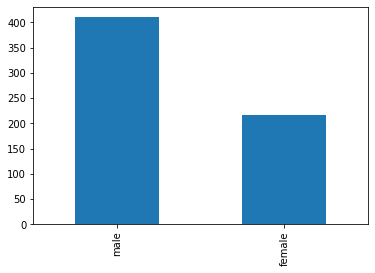

In [14]:
# Observe and get to know structure and characteristics of data (Not Required to Run Model)
dftrain['sex'].value_counts().plot(kind='bar')


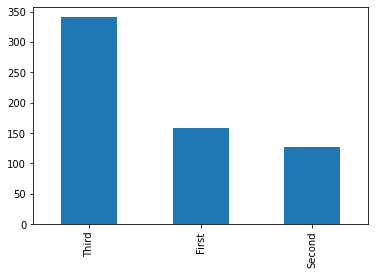

In [15]:
# Observe and get to know structure and characteristics of data (Not Required to Run Model)
dftrain['class'].value_counts().plot(kind='bar')

In [16]:
# setup features for model 

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERICAL_COLUMNS = ['age', 'fare']

feature_columns = [] 

# iterate through categorical columns
for feature_name in CATEGORICAL_COLUMNS: 
    vocabulary = dftrain[feature_name].unique() # get all the unique values for each category (ex. Sex would M/F)
    new_feature = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary) # creates a feature for a category and all the unique entries
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) # add the feature to the list  

# iterate through numerical columns 
for feature_name in NUMERICAL_COLUMNS: 
    new_feature = tf.feature_column.numeric_column(feature_name, dtype = tf.float32) # create a feature with the category and a float value
    feature_columns.append(new_feature) # give feature name and data type for numeric # add the features to the list

In [38]:
# Create an input function that will convert our pandas dataframe into a tf.data.dataset obj, source: https://www.tensorflow.org/tutorials/estimator/linear
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=100):
  def input_function():  # Nested function 
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    # example of repeat and batch method are used:
    # repeat: [1, 2, 3].repeat(3) -> [1, 2, 3, 1, 2, 3, 1, 2, 3]
    # batch: dataset = tf.data.Dataset.range(8).batch(3) -> [[0, 1, 2], [3, 4, 5], [6, 7]]
    return ds  # return batch 
  return input_function  # return dataset object 

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [39]:
# Create model with feature columns 
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp7_bexw5n', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [41]:
# train model with function 
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.75
